# Epsilon ablation studies
In this notebook we present the code used for ablation studies published in our paper. **By default, precomputed results will be loaded** and printed out. **If you wish to run the ablations from scratch**, change the `results_dir` directory name from `release_results` to any other name you please.

In [4]:
import os
import json
import data
import itertools

import numpy as np
import pickle as pkl
import seaborn as sns
from tqdm import trange
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import torch

from utils import batchify
from argparse import Namespace
from model import AWDRNNModel
from train import train, evaluate
from utils import get_batch
from multilinear import MultiLinear
from custom_rnn import CustomRNNCell, CustomRNN
from weight_drop import ParameterListWeightDrop
from epsinas_utils import compute_epsinas, prepare_seed, prepare_recepies, compute_stats, plot_results

In [5]:
# Change to a different name if you would like to run ablation tests from scratch
results_dir = '../epsinas-release-data/NAS-Bench-NLP'

In [5]:
# Prepare a fixed batch of data
file_list=os.listdir("train_logs_single_run/")
log_dflt = json.load(open('train_logs_single_run/' + file_list[0], 'r'))
args = Namespace(**log_dflt)
corpus = data.Corpus(args.data)

if torch.cuda.is_available():
    args.cuda = True
    device = "cuda"
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    
else:
    args.cuda = False
    device = "cpu"
    
device = torch.device(device)

ntokens = len(corpus.dictionary)
batch_size = 256

train_eval_data = batchify(corpus.train, batch_size, args, device)
x, _ = get_batch(train_eval_data, 0, args, evaluation=True)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




In [6]:
# Reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
prepare_seed(21)

In [7]:
len(train_eval_data)

3631

## Weight ablations

In this ablation study we verify how much does the performance of epsilon metric change depending on the chosen weights. Since we can only run epsilon computation for NAS-Bench-NLP only on CPU, we perform this study only for 1000 data points.

In [8]:
weight_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
it = 0
for (weight_l, weight_h) in itertools.product(weight_range, weight_range):
    
    if weight_h>weight_l:
        save_dir = f'{results_dir}/ablation/weights/weights_{weight_l}_{weight_h}/'
        os.makedirs(save_dir, exist_ok=True)
        if os.path.exists(save_dir+'data'):
            # Load precomputed results
            datafile = open(save_dir+'data','rb')
            data = pkl.load(datafile)
            scores = data["scores"]
            accs = data["accs"]
            nparams = data["nparams"]
            datafile.close()
        else:
            accs = []
            nparams = []
            scores = []
            weights = [weight_l, weight_h]
            
            for i in trange(5000):
                file = file_list[i]
                log = json.load(open('train_logs_single_run/' + file, 'r'))
                args = Namespace(**log)

                # Build the model
                network = AWDRNNModel(args.model,
                                      ntokens,
                                      args.emsize,
                                      args.nhid,
                                      args.nlayers,
                                      args.dropout,
                                      args.dropouth,
                                      args.dropouti,
                                      args.dropoute,
                                      args.wdrop,
                                      args.tied,
                                      args.recepie,
                                      verbose=False)
                network = network.to(device)
                score = compute_epsinas(x, network, weights, batch_size)
                scores.append(score)
                nparams.append(args.num_params)
                try:
                    accs.append(log['test_losses'][-1])
                except:
                    accs.append(np.nan) 

            save_dic = {}
            save_dic["scores"] = scores
            save_dic["accs"] = accs
            save_dic["nparams"] = nparams
            pkl.dump(save_dic, open(save_dir + "data", "wb"))
            
        if it==0:
            # Make the table
            headers = ["Weights", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
            table = PrettyTable(headers)
        stats, remain = compute_stats(scores, accs)
        stats_print = ["[{}, {}]".format(weight_l, weight_h), remain] + stats        
        table.add_row(stats_print)
        it+=1
        
#         scores_plot = np.array(scores)[np.array(scores)>0.00001]
#         accs_plot = np.array(accs)[np.array(scores)>0.00001]
#         nparams_plot = np.array(nparams)[np.array(scores)>0.00001]
        
#         plot_results(scores=scores_plot,
#                      accs=accs_plot,
#                      nparams=nparams_plot,
#                      top10=False,
#                      log_scale=True,
#                      save_dir=save_dir,
#                      save_name="epsinas_{}_{}".format(weight_l, weight_h))
    

In [9]:
table

Weights,Archs,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
"[1e-07, 1e-06]",1663,-0.14,0.25,-0.10,0.14,0.00,0.00
"[1e-07, 1e-05]",2211,-0.30,0.60,-0.20,0.46,1.82,0.00
"[1e-07, 0.0001]",2325,-0.35,0.53,-0.24,0.40,0.43,1.00
"[1e-07, 0.001]",2304,-0.40,0.52,-0.27,0.39,3.03,1.00
"[1e-07, 0.01]",914,-0.49,0.02,-0.34,0.02,3.30,1.00
"[1e-07, 0.1]",465,-0.30,0.26,-0.21,0.18,14.89,7.00
"[1e-07, 1]",395,-0.12,0.11,-0.08,0.03,12.50,7.00
"[1e-06, 1e-05]",2806,-0.21,0.55,-0.13,0.40,1.07,0.00
"[1e-06, 0.0001]",3234,-0.24,0.41,-0.16,0.30,0.62,0.00
"[1e-06, 0.001]",3211,-0.33,0.32,-0.22,0.24,4.67,1.00


## Embedding ablations

In [10]:
embedding_names = ["uniform_positive_0.1",
                   "uniform_positive_1",
                   "uniform_centered_0.1",
                   "uniform_centered_1",
                   "random_0.1",
                   "random_1"]

In [11]:
from multilinear import MultiLinear
from custom_rnn import CustomRNNCell, CustomRNN
from weight_drop import ParameterListWeightDrop

import torch.nn as nn

weight_l = 1e-5
weight_h = 1e-3
it = 0
for embedding_name in embedding_names:
    save_dir = f'{results_dir}/ablation/embedding/{embedding_name}/'
    os.makedirs(save_dir, exist_ok=True)
    if os.path.exists(save_dir+'data'):
        # Load precomputed results
        data_file = open(save_dir+'data','rb')
        data = pkl.load(data_file)
        scores = data["scores"]
        accs = data["accs"]
        nparams = data["nparams"]
    else:
        accs = []
        nparams = []
        scores = []
        for i in trange(1000):
            file = file_list[i]
            log = json.load(open('train_logs_single_run/' + file, 'r'))
            args = Namespace(**log)

            # Build the model
            network = AWDRNNModel(args.model,
                                  ntokens,
                                  args.emsize,
                                  args.nhid,
                                  args.nlayers,
                                  args.dropout,
                                  args.dropouth,
                                  args.dropouti,
                                  args.dropoute,
                                  args.wdrop,
                                  args.tied,
                                  args.recepie,
                                  verbose=False)
            network = network.to(device)
            preds = []
            for weight in [weight_l, weight_h]:
                # Initialize
                prepare_seed(21)
                def initialize_resnet(m):
                    if type(m)==MultiLinear:
                        for par in m.weights_raw:
                            nn.init.constant_(par, weight)
                    elif type(m)==CustomRNNCell:
                        for par in m.parameters():
                            nn.init.constant_(par, weight)
                    elif type(m)==nn.modules.linear.Linear:
                        nn.init.constant_(m.weight, weight)
                    elif type(m)==nn.modules.container.ParameterList:
                        for par in m.parameters():
                            nn.init.constant_(par, weight)
                    elif type(m)==CustomRNN:
                        initialize_resnet(m.cell)
                    elif type(m)==ParameterListWeightDrop:
                        initialize_resnet(m.module)
                    elif type(m)==nn.modules.container.ModuleDict:
                        for sub_m in m:
                            initialize_resnet(sub_m)
                    elif type(m)==nn.modules.container.ModuleList:
                        for sub_m in m:
                            initialize_resnet(sub_m)
                    elif type(m)==AWDRNNModel:
                        initialize_resnet(m.rnns)

                network.apply(initialize_resnet)
                score = compute_epsinas(x, network, weights, batch_size)
                scores.append(score)
                nparams.append(args.num_params)
            scores.append(mae/mean)
            nparams.append(args.num_params)
            try:
                accs.append(log['test_losses'][-1])
            except:
                accs.append(np.nan) 

        save_dic = {}
        save_dic["score"] = scores
        save_dic["accs"] = accs
        save_dic["nparams"] = nparams
        pkl.dump(save_dic, open(save_dir + "Data", "wb"))

    if it==0:
        # Make the table
        headers = ["Data", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
        table = PrettyTable(headers, align='l')
    stats, remain = compute_stats(scores, accs)
    stats_print = [embedding_name, remain] + stats       
    table.add_row(stats_print)
    it+=1

#     plot_results(scores=scores,
#                  accs=accs,
#                  nparams=nparams,
#                  top10=False,
#                  log_scale=True,
#                  save_dir=save_dir,
#                  save_name="epsinas_{}".format(embedding_name))
    

In [12]:
table

Data,Archs,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
uniform_positive_0.1,782,-0.38,0.17,-0.26,0.15,3.80,2.00
uniform_positive_1,776,-0.37,0.21,-0.26,0.18,2.56,2.00
uniform_centered_0.1,783,-0.40,0.18,-0.28,0.15,2.53,2.00
uniform_centered_1,782,-0.46,0.18,-0.33,0.16,1.27,1.00
random_0.1,783,-0.42,0.18,-0.29,0.15,2.53,2.00
random_1,782,-0.47,0.19,-0.33,0.16,1.27,1.00


## Batch size

In [6]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512, 1024]

weight_l = 1e-5
weight_h = 1e-3
it = 0

batch_all_spearman_all = []
batch_top10_spearman_all = []
batch_all_kendall_all = []
batch_top10_kendall_all = []
batch_top10top10_all = []
batch_top64top5_all = []

for batch_size in batch_size_range:
    batch_all_spearman = []
    batch_top10_spearman = []
    batch_all_kendall = []
    batch_top10_kendall = []
    batch_top10top10 = []
    batch_top64top5 = []
    
    for it in range(3):
        save_dir = f'{results_dir}/ablation/batch_size/batch_size_{batch_size}/'
        os.makedirs(save_dir, exist_ok=True)
        
        if os.path.exists(save_dir+'data_' + str(it)):
            print(save_dir+'data_' + str(it) + " exists!")
            # Load precomputed results
            datafile = open(save_dir + 'data_' + str(it),'rb')
            data = pkl.load(datafile)
            scores = data["scores"]
            accs = data["accs"]
            nparams = data["nparams"]
            datafile.close()
        else:
            # Load the data batch
            if it==0:
                train_eval_data = batchify(corpus.train, batch_size, args, device)
                ind = np.random.choice(range(len(train_eval_data)-args.bptt), 5, replace=False)
            x, _ = get_batch(train_eval_data, ind[it], args, evaluation=True)
            
            accs = []
            nparams = []
            score = []
            for i in trange(1000):
                file = file_list[i]
                log = json.load(open('train_logs_single_run/' + file, 'r'))
                args = Namespace(**log)

                # Build the model
                network = AWDRNNModel(args.model,
                                      ntokens,
                                      args.emsize,
                                      args.nhid,
                                      args.nlayers,
                                      args.dropout,
                                      args.dropouth,
                                      args.dropouti,
                                      args.dropoute,
                                      args.wdrop,
                                      args.tied,
                                      args.recepie,
                                      verbose=False)
                network = network.to(device)
                # Need to explicitely implement the epsinas computation for RNN
                # because initialization takes the batch size as an argument
                # and it is the easiest way to do
                preds = []
                for weight in [weight_l, weight_h]:
                    # Initialize
                    prepare_seed(21)
                    def initialize_resnet(m):
                        if type(m)==MultiLinear:
                            for par in m.weights_raw:
                                nn.init.constant_(par, weight)
                        elif type(m)==CustomRNNCell:
                            for par in m.parameters():
                                nn.init.constant_(par, weight)
                        elif type(m)==nn.modules.linear.Linear:
                            nn.init.constant_(m.weight, weight)
                        elif type(m)==nn.modules.container.ParameterList:
                            for par in m.parameters():
                                nn.init.constant_(par, weight)
                        elif type(m)==CustomRNN:
                            initialize_resnet(m.cell)
                        elif type(m)==ParameterListWeightDrop:
                            initialize_resnet(m.module)
                        elif type(m)==nn.modules.container.ModuleDict:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        elif type(m)==nn.modules.container.ModuleList:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        elif type(m)==AWDRNNModel:
                            initialize_resnet(m.rnns)

                    network.apply(initialize_resnet)
                    network.eval()
                    hidden = network.init_hidden(batch_size, weight)
                    nn.init.uniform_(network.encoder.weight, 0, 1)
                    _, _, raw_output, _ = network(x, hidden=hidden, return_h=True)
                    pred = raw_output[-1][:,:,0].cpu().flatten()
                    pred = pred.numpy()
                    pred_min = np.nanmin(pred)
                    pred_max = np.nanmax(pred)
                    pred_norm = (pred - pred_min)/(pred_max - pred_min)
                    preds.append(pred_norm)

                # Compute the score
                preds = np.array(preds)
                preds[np.where(preds==0)] = np.nan
                mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
                mean = np.nanmean(preds)

                score.append(mae/mean)
                nparams.append(args.num_params)
                try:
                    accs.append(log['test_losses'][-1])
                except:
                    accs.append(np.nan)

            save_dic = {}
            save_dic["scores"] = scores
            save_dic["accs"] = accs
            save_dic["nparams"] = nparams
            pkl.dump(save_dic, open(save_dir + "data_" + str(it), "wb"))

        stats, _ = compute_stats(scores, accs, maximize=False, raw=True)
        batch_all_spearman.append(stats[0])
        batch_top10_spearman.append(stats[1])
        batch_all_kendall.append(stats[2])
        batch_top10_kendall.append(stats[3])
        batch_top10top10.append(stats[4])
        batch_top64top5.append(stats[5])

    batch_all_spearman_all.append(batch_all_spearman)
    batch_top10_spearman_all.append(batch_top10_spearman)
    batch_all_kendall_all.append(batch_all_kendall)
    batch_top10_kendall_all.append(batch_top10_kendall)
    batch_top10top10_all.append(batch_top10top10)
    batch_top64top5_all.append(batch_top64top5)

../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_8/data_0 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_8/data_1 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_8/data_2 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_16/data_0 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_16/data_1 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_16/data_2 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_32/data_0 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_32/data_1 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_32/data_2 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_64/data_0 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation/batch_size/batch_size_64/data_1 exists!
../epsinas-release-data/NAS-Bench-NLP/ablation

/home/gracheva/Work/epsinas/NAS-Bench-NLP/epsinas_utils.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','8','16','32','64','128','256','512','1024'])


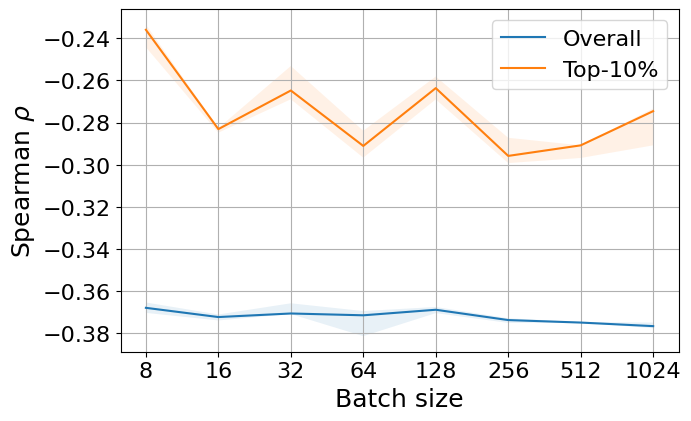

In [7]:
from epsinas_utils import bs_ablation_plots

save_dir = f'{results_dir}/ablation/batch_size/'
filename = save_dir+"BatchSize_Spearman_NLP_Single.png"
bs_ablation_plots([(batch_all_spearman_all,'Overall'), (batch_top10_spearman_all,'Top-10%')], filename)